In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 12

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 12)                132       
                                                                 
Total params: 1,202
Trainable params: 1,202
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
print(len(X_test), len(y_test))

9350 9350


In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
207/220 [===========================>..] - ETA: 0s - loss: 2.2843 - accuracy: 0.1744  
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
220/220 [==============================] - 1s 2ms/step - loss: 2.2758 - accuracy: 0.1773 - val_loss: 1.9866 - val_accuracy: 0.2780
Epoch 2/1000
201/220 [==========================>...] - ETA: 0s - loss: 1.9859 - accuracy: 0.2594
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
220/220 [==============================] - 0s 2ms/step - loss: 1.9758 - accuracy: 0.2618 - val_loss: 1.6332 - val_accuracy: 0.4384
Epoch 3/1000
218/220 [============================>.] - ETA: 0s - loss: 1.7613 - accuracy: 0.3183
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
220/220 [==============================] - 0s 2ms/step - loss: 1.7606 - accuracy: 0.3186 - val_loss: 1.3827 - val_accuracy: 0.5686
Epoch 4/1000
173/220 [======================>.......] - ETA: 0s - loss: 1.6317 - ac

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

74/74 [==============================] - 0s 1ms/step - loss: 0.8457 - accuracy: 0.6710


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 77ms/step
[1.7889879e-05 1.3305285e-02 5.1060241e-01 3.7396266e-03 2.8387434e-04
 3.3311039e-01 5.5786677e-06 1.2531939e-04 2.9921934e-03 6.9815790e-08
 1.3414280e-01 1.6746511e-03]
2


# Confusion matrix

293/293 [==============================] - 0s 783us/step


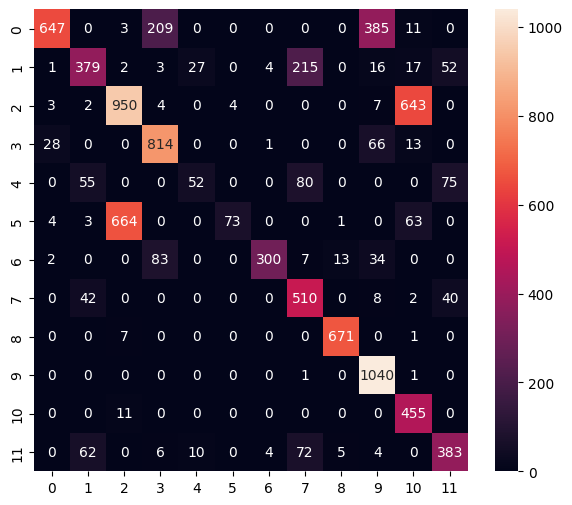

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.52      0.67      1255
           1       0.70      0.53      0.60       716
           2       0.58      0.59      0.58      1613
           3       0.73      0.88      0.80       922
           4       0.58      0.20      0.30       262
           5       0.95      0.09      0.16       808
           6       0.97      0.68      0.80       439
           7       0.58      0.85      0.69       602
           8       0.97      0.99      0.98       679
           9       0.67      1.00      0.80      1042
          10       0.38      0.98      0.54       466
          11       0.70      0.70      0.70       546

    accuracy                           0.67      9350
   macro avg       0.73      0.67      0.64      9350
weighted avg       0.74      0.67      0.65      9350



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp2znezctl\assets


6840

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 3.99 ms


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.7889875e-05 1.3305295e-02 5.1060236e-01 3.7396278e-03 2.8387454e-04
 3.3311036e-01 5.5786777e-06 1.2531949e-04 2.9921946e-03 6.9815840e-08
 1.3414285e-01 1.6746515e-03]
2
